366
Date
2024-01-01    242779
2024-01-02    255750
2024-01-03    260443
2024-01-04    260372
2024-01-05    258788
Name: Actual AIL, dtype: int64


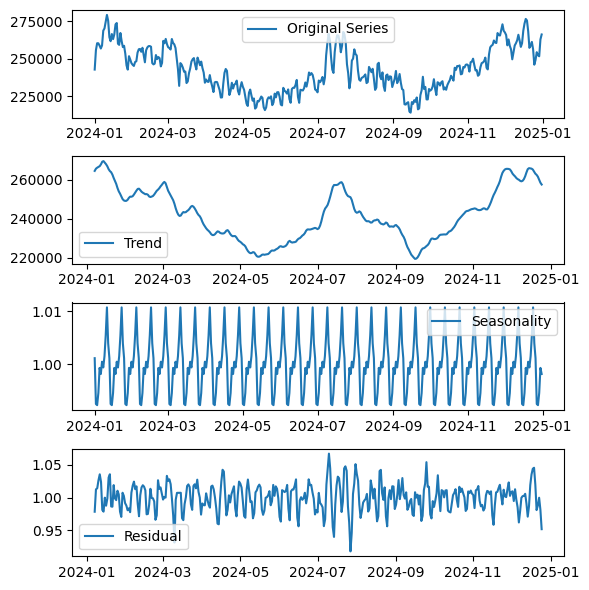

In [2]:
# Demand forecast
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

################### Load Data #####################################
df1 = pd.read_csv('2024ActualForecastData.csv')
df1['Date'] = pd.to_datetime(df1['Date'])
demand_data = df1.groupby(df1['Date'].dt.date)['Actual AIL'].sum() # Groups data by date, but this is a series
print(len(demand_data))
print(demand_data.head())

# Identify seasonal components
result = seasonal_decompose(demand_data, model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(demand_data, label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
################################# Stationary Check (ADF test) #######################################
# ADF tests the null hypothesis that there is the existence of a unit root in the time series sample.
# The presence of a unit root implies that the time series is non-stationary, that is, the time series
# does not necessarily have a deterministic trend.

def adftest(dataset):
    try:
        result = adfuller(dataset, autolag='AIC')
        if result[1] < 0.05:
            print('Time Series is Stationary')
        else:
            print('Fail to reject null hypothesis. Time Series is Non-Stationary')
    except Exception as e:
        print('Invalid dataset: {e}')

adftest(demand_data)

Fail to reject null hypothesis. Time Series is Non-Stationary


Time Series is Stationary


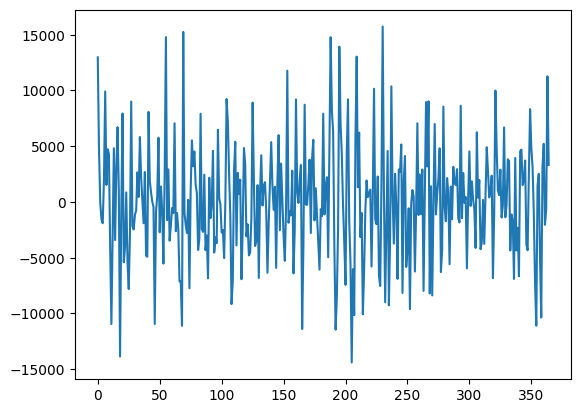

In [4]:
################################ Differencing ##########################################
# Differencing is a method used to transform a non-stationary time series by calculating
# the difference between consecutive observation. y'_t = y_t - y_(t-1)
# It can stabilize the mean of a non-stationary time series by removing changes in
# level of a time series.

def difference(dataset, interval = 1):
    diff = []
    for i in range(interval, len(dataset)):
        diff.append(dataset.iloc[i] - dataset.iloc[i - interval])
    return pd.Series(diff)

adftest(difference(demand_data))
difference(demand_data).plot()
plt.show()



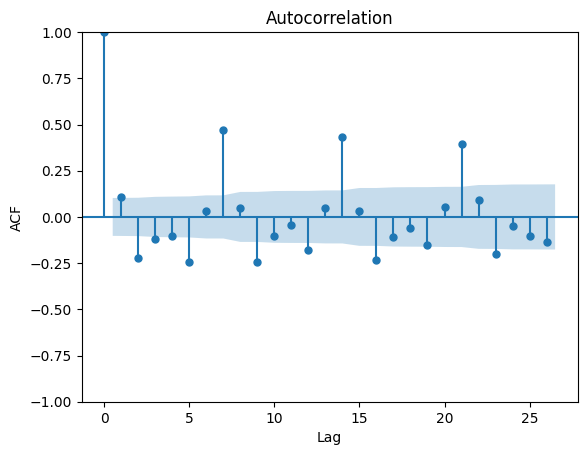

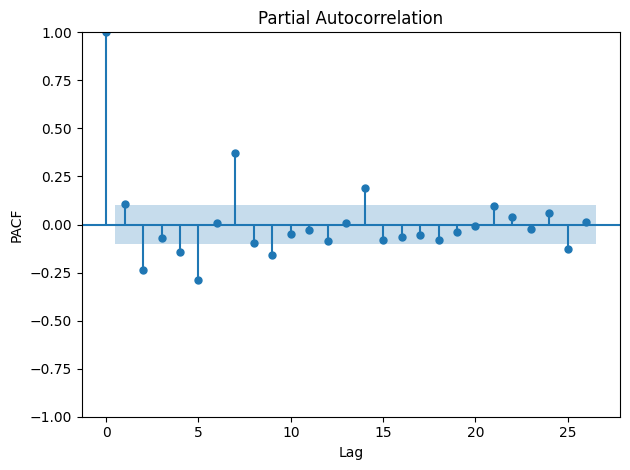

In [5]:
################################### Model Parameter ###########################################
# Autocorrelation function measures how much of the past values (lagged values) affects the current value.
# Partial Autocorrelation function measures how much of the k-th lagged value directly affects the current value.
plot_acf(difference(demand_data))
plt.xlabel('Lag')
plt.ylabel('ACF')

plot_pacf(difference(demand_data))
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()


                                      SARIMAX Results                                      
Dep. Variable:                          Actual AIL   No. Observations:                  311
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -3012.233
Date:                             Thu, 26 Feb 2026   AIC                           6030.466
Time:                                     23:11:49   BIC                           6041.676
Sample:                                 01-01-2024   HQIC                          6034.948
                                      - 11-06-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9919      0.006    169.273      0.000       0.980       1.003
ma.S.L7       -0.9720      

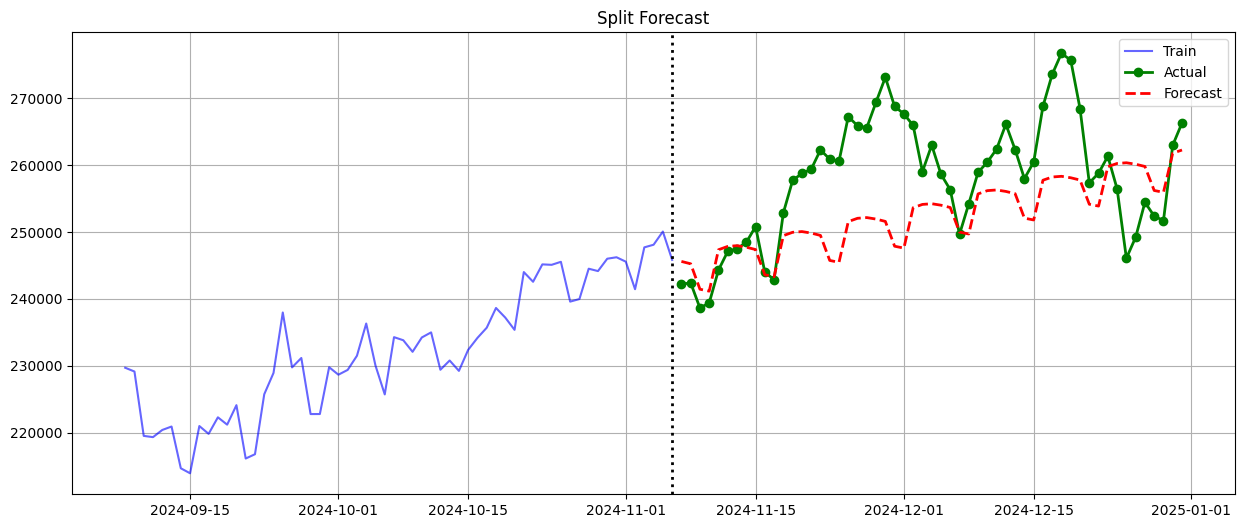


MAE: 7,790 MW
RMSE: 9,843 MW


In [6]:
##################### SARIMA Model ######################################
# Model with no exogenous variables
# SARIMAX model can automatically differentiate the non-stationary series, so we can use the
# original data.

# A function to split data for training and testing
def split_point(data, trainSize):
    """
    :param data: Time Series DataFrame
    :param trainSize: Training set size proportion ie 80% of series is used for training
    :return: train data, test data
    """
    split_ind = int(len(data) * trainSize)
    train = data[:split_ind]
    test = data[split_ind:]
    return train, test

train , test = split_point(demand_data, 0.85)
train = train.asfreq('D')
test = test.asfreq('D')

model1 = SARIMAX(
    train,
    order = (0, 1, 0),
    seasonal_order = (1, 0, 1, 7)
)
results1 = model1.fit()
print(results1.summary())

forecast1 = results1.forecast(steps=len(test))
forecast1.index = test.index

# Plot
plt.figure(figsize=(15, 6))
plt.plot(train.index[-60:], train.values[-60:], 'b-', label='Train', alpha=0.6)
plt.plot(test.index, test.values, 'go-', label='Actual', linewidth=2)
plt.plot(forecast1.index, forecast1.values, 'r--', label='Forecast', linewidth=2)
plt.axvline(train.index[-1], color='black', linestyle=':', linewidth=2)
plt.legend()
plt.title('Split Forecast')
plt.grid(True)
plt.show()

# AIC most commonly refers to the Akaike Information Criterion, a statistical metric used to compare,
# select, and evaluate the quality of models based on their goodness of fit and simplicity.
# Lower AIC values indicate a better-fitting model with fewer variables.

# Accuracy
print(f"\nMAE: {mean_absolute_error(test, forecast1):,.0f} MW")
print(f"RMSE: {np.sqrt(mean_squared_error(test, forecast1)):,.0f} MW")

                0      1      2      3      4      5      6
Date                                                       
2024-01-01   True  False  False  False  False  False  False
2024-01-02  False   True  False  False  False  False  False
2024-01-03  False  False   True  False  False  False  False
2024-01-04  False  False  False   True  False  False  False
2024-01-05  False  False  False  False   True  False  False
                                      SARIMAX Results                                      
Dep. Variable:                          Actual AIL   No. Observations:                  311
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -3048.392
Date:                             Thu, 26 Feb 2026   AIC                           6116.785
Time:                                     23:11:50   BIC                           6154.151
Sample:                                 01-01-2024   HQIC                          6131.722
                            

C:\Users\rchl\PyCharmMiscProject\Alberta Energy Market Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


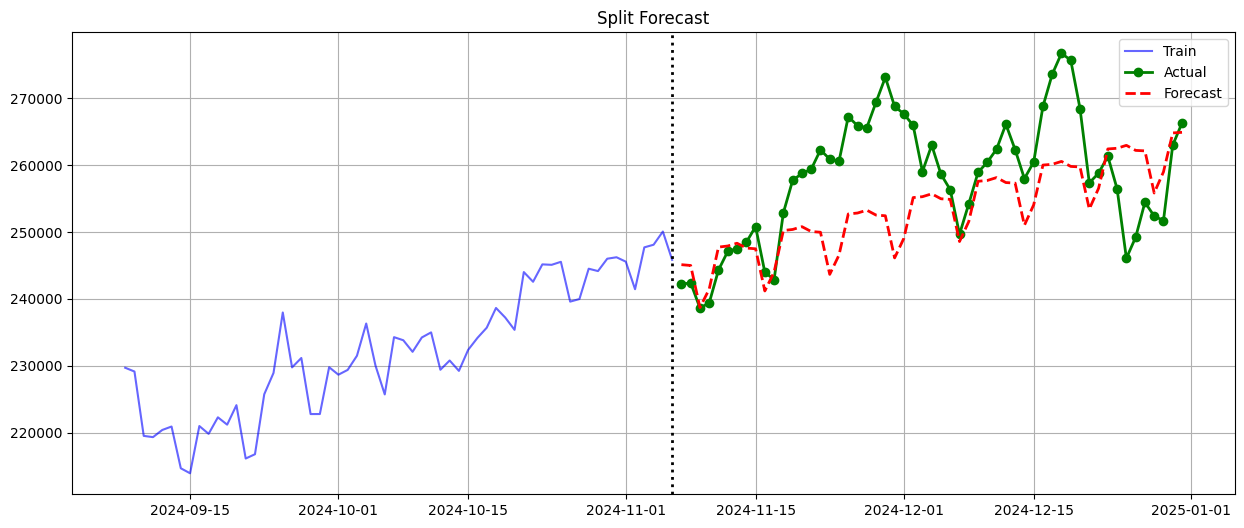


MAE: 7,348 MW
RMSE: 9,463 MW


In [7]:
############################# SARIMAX Model #####################################
# A function to extract exogenous variables
def dayVar(data):
    """
    :param data: Series with DatetimeIndex
    :return: DataFrame with day of the week dummies
    """
    # Convert index to DatetimeIndex if needed
    if not isinstance(data.index, pd.DatetimeIndex):
        data = data.copy()
        data.index = pd.to_datetime(data.index)
    df = pd.DataFrame(index=data.index)
    df['Day'] = data.index.dayofweek

    # Dummy variable
    dayDum = pd.get_dummies(df['Day'])
    return dayDum

print(dayVar(demand_data).head())

train, test = split_point(demand_data, 0.85)
train = train.asfreq('D')
test = test.asfreq('D')
# Create exog data
exog_train = dayVar(train)
exog_test = dayVar(test)

model2 = SARIMAX(
    train,
    exog=exog_train,
    order = (0, 1, 0),
    seasonal_order=(1, 0, 1, 7),
)

results2 = model2.fit()
print(results2.summary())

# Forecast
forecast2 = results2.forecast(steps=len(test), exog=exog_test)
forecast2.index = test.index

# Plot
plt.figure(figsize=(15, 6))
plt.plot(train.index[-60:], train.values[-60:], 'b-', label='Train', alpha=0.6)
plt.plot(test.index, test.values, 'go-', label='Actual', linewidth=2)
plt.plot(forecast2.index, forecast2.values, 'r--', label='Forecast', linewidth=2)
plt.axvline(train.index[-1], color='black', linestyle=':', linewidth=2)
plt.legend()
plt.title('Split Forecast')
plt.grid(True)
plt.show()

# Accuracy
print(f"\nMAE: {mean_absolute_error(test, forecast2):,.0f} MW")
print(f"RMSE: {np.sqrt(mean_squared_error(test, forecast2)):,.0f} MW")


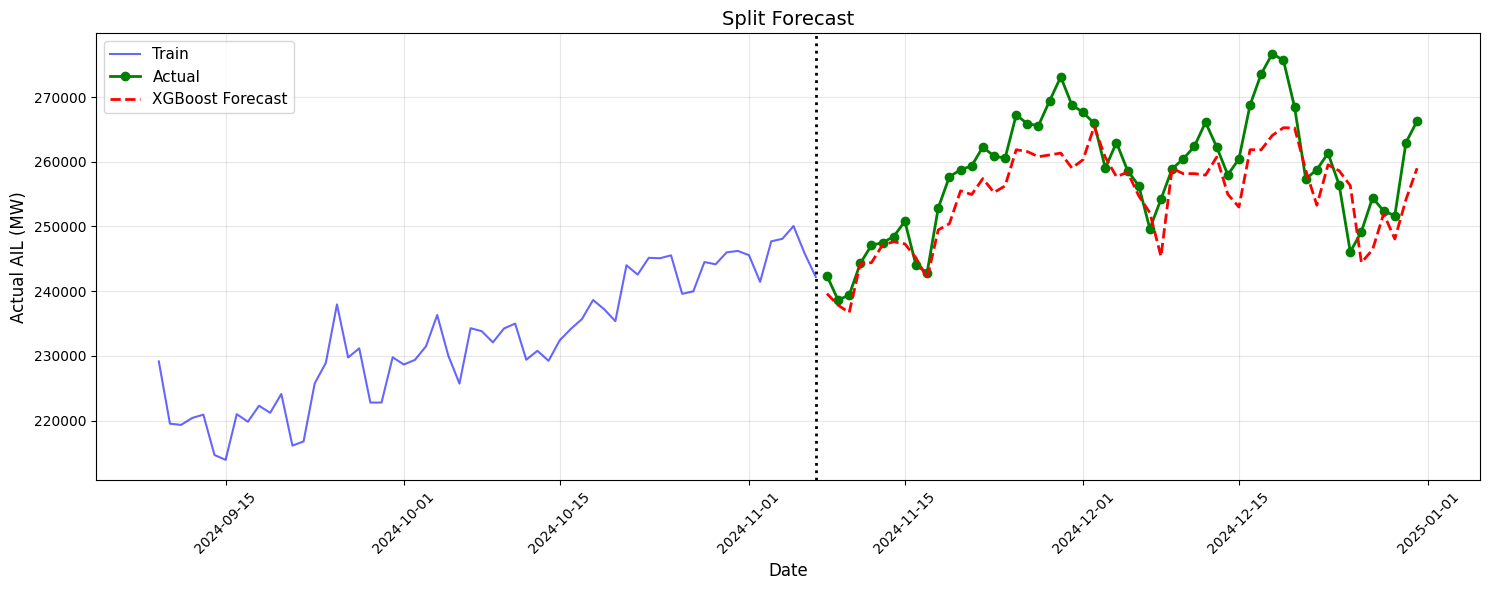

MAE:  4,569 MW
RMSE: 5,688 MW
     feature  importance
2       lag1    0.628092
4        MA7    0.234786
3       lag7    0.051797
0        day    0.050597
1  dayofyear    0.034727


In [9]:
# Forecast using XGBoost

# A function that creates numerical features
def create_features(data):
    """
    :param data: Series with DatetimeIndex
    :return: DataFrame
    """
    # Convert demand_data from a series into a data frame
    data_df = data.to_frame().reset_index()
    data_df['Date'] = pd.to_datetime(data_df['Date'])

    data = data_df.copy()

    # Time features
    data['day'] = data['Date'].dt.dayofweek
    data['dayofyear'] = data['Date'].dt.dayofyear

    # Lagged features, how much the previous day affects the current day ie. Autoregression
    data['lag1'] = data['Actual AIL'].shift(1) # Yesterday
    data['lag7'] = data['Actual AIL'].shift(7) # Same day last week

    # Moving Average
    data['MA7'] = data['Actual AIL'].shift(1).rolling(7).mean() # Weekly Avg

    return data.dropna()

train, test = split_point(create_features(demand_data), 0.85)

X_train = train.drop(['Date','Actual AIL'], axis=1) # Features used to predict
X_test = test.drop(['Date','Actual AIL'], axis=1)
Y_train = train['Actual AIL'] # Target, what is getting predicted
Y_test = test['Actual AIL']

model3 = xgb.XGBRegressor(
    n_estimators=100,  # Number of trees to build
    learning_rate=0.1, # How much each tree contributes
    max_depth=2,       # How many levels of questions
    random_state=42
)

result3 = model3.fit(X_train, Y_train)

# Forecast
forecast3_train = model3.predict(X_train)
forecast3_test = model3.predict(X_test)

############################################# Plot #############################################
plt.figure(figsize=(15, 6))
# Plot last 60 days of training data
plt.plot(train['Date'].iloc[-60:], train['Actual AIL'].iloc[-60:],'b-', label='Train', alpha=0.6)

# Plot actual test values
plt.plot(test['Date'], Y_test,'go-', label='Actual', linewidth=2)

# Plot XGBoost predictions
plt.plot(test['Date'], forecast3_test,'r--', label='XGBoost Forecast', linewidth=2)

# Vertical line at train/test split
plt.axvline(train['Date'].iloc[-1], color='black', linestyle=':', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Actual AIL (MW)', fontsize=12)
plt.title('Split Forecast', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model3.feature_importances_
}).sort_values('importance', ascending=False)

# Accuracy
print(f"MAE:  {mean_absolute_error(Y_test, forecast3_test):,.0f} MW")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test, forecast3_test)):,.0f} MW")
print(feature_importance)
